In [1]:
import math, random
import numpy as np
import pandas as pd # Para imprimir as listas de forma mais clara
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.expand_frame_repr', False)
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Jupyter interativo
from ipywidgets import interactive, fixed
%matplotlib inline

## Implementação
Foi implementada duas classes, responsáveis pela execução do algoritmo diferencial dos 2 problemas/função Peaks e Rastrigin e por este motivo, preferiu-se enviar somente um arquivo contendo toda a análise, uma vez que muda pouca coisa para alterar a função. 

Uma classe (Individuo_Particula) foi responsável por representar a partícula, contendo variáveis como sua posição, velocidade, melhorPosicao dessa partícula e melhorPontuacao dessa partícula.

Uma classe (Algoritmo_Swarm) foi responsável pelo algoritmo Swarm em sí, armazenando todo o "enxame" de partículas (população) e por rodar o algorítmo em sí, como foi abordado abaixo.

Optou-se por remanejar o código do TP anterior para ficar mais facil de visualizar o códio e entendê-lo.
O código foi adaptado do pseudo-código disponibilizado na apresentação do trabalho e escolheu-se retornar 2 variáveis dessa função principal(run), para obter o gráfico de sua evolução.

Toda a análise e uso de funções para plotar gráficos e observar o resultado foi utilizando esses 2 valores, como pode-se observar abaixo na implementação da classe Individuo_Particulo, Algoritmo_Swarm, das funções e nas análises do algoritmo para as funções Peaks e Rastrigin.

### Condição de Parada/Convergência
Definiu-se 2 condições de parada:
1. O algoritmo parava caso o número de gerações ultrapasse um número de gerações máximas pré-definidos
2. O algoritmo parava caso a média, arredondada de 4 algarismos, permanecesse a mesma nas últimas 3 gerações

### Ajuste de velocidade
Foram propostas 2 alternativas para ajustar a velocidade caso ela estrapole a velocidade máxima:
- Refletir a velocidade
- Truncar a velocidade

Para este trabalho, pela facilidade, optou-se por truncar a velocidade para a velocidade máxima, caso o cálculo da velocidade da partícula exceda o máximo estipulado.

In [2]:
def Peaks(x):
    F = 3*(1-x[0])**2*math.exp(-(x[0]**2) - (x[1]+1)**2) \
       - 10*(x[0]/5 - x[0]**3 - x[1]**5)*math.exp(-x[0]**2-x[1]**2) \
       - 1/3*math.exp(-(x[0]+1)**2 - x[1]**2) 
    return F
    
    
def Rastrigin(x):
    Q = np.eye(len(x))
    X = np.matmul(Q,x)
    n = len(X)
    F = 0
    for i in range(n):
        F = F + X[i]**2 - 10*math.cos(2*math.pi*X[i])
    return F

In [3]:
class Individuo_Particula():
    def __init__(self,tipo='peaks'):
        self.type = tipo
        if tipo == 'peaks':
            self.posicao = np.random.uniform(-3, 3,size=2)
        elif tipo == 'rastrigin':
            self.posicao = np.random.uniform(-2, 2,size=2)
        self.velocidade = [0,0]
        self.melhorPosicao = self.posicao # Melhor posicao inicial é a posicao iniciada
        self.melhorPontuacao = self.Funcao(self.posicao)  # Melhor pontuacao inicial é a pontuacao da posicao inicial
     
        
    def Funcao(self,x):
        if self.type == 'peaks':
            return Peaks(x)
        elif self.type == 'rastrigin':
            return Rastrigin(x) 
        
        
    def AtualizarVelocidade(self,w,c1,c2,melhorPosGlobal,vMAX = [1,1]):
        velocidade = [0,0]
        for i in range(len(self.velocidade)): # Para cada dimensao d
            p1, p2 = [random.uniform(0, 1) for i in range(2)]
            velocidade_cognitiva = (p1*c1*(self.melhorPosicao[i] - self.posicao[i]))
            velocidade_social = (p2*c2*(melhorPosGlobal[i]         - self.posicao[i]))
            velocidade[i] = (w*self.velocidade[i]) + velocidade_cognitiva + velocidade_social
                                                    
            if velocidade[i] > vMAX[i]: # Truncar velocidade
                velocidade[i] = vMAX[i]
            if -velocidade[i] < -vMAX[i]:
                velocidade[i] = -vMAX[i]
               
        self.velocidade = velocidade
#         print(velocidade)
        return self.velocidade
    
    
    def AtualizarPosicao(self):
        for i in range(len(self.posicao)): # Para cada dimensao d
            self.posicao[i] = self.posicao[i] + self.velocidade[i]

In [4]:
class Algoritmo_Swarm():
    def __init__(self,nPopulacao,tipo='peaks'):
        self.N = nPopulacao # Numero de particulas
        self.population = [Individuo_Particula(tipo) for i in range(nPopulacao)]

    def getMinAptidaoVizinhos(self): 
        pontuacoes = [Particula.Funcao(Particula.posicao) for Particula in self.population]
        min_valor = min(pontuacoes)     
        min_index = pontuacoes.index(min_valor)
        return self.population[min_index] # Retorna o individuo com a menor pontuacao
        
    
    def run(self,w=0.5,c1=1,c2=1,maxgen=500):
        ngen=0
        melhoresPontuacoes = []
        mediasPontuacoes = []
        while ngen < maxgen: 
            for i,Particula in enumerate(self.population): # Para as N partículas
                f_xi = Particula.Funcao(Particula.posicao) # Avaliar f(xi)
                if f_xi < Particula.melhorPontuacao:
                    Particula.melhorPosicao = Particula.posicao
                    Particula.melhorPontuacao = f_xi
                g = self.getMinAptidaoVizinhos() # G = min(pvizinhos)           
                Particula.AtualizarVelocidade(w=w,c1=c1,c2=c2,melhorPosGlobal=g.posicao)
                Particula.AtualizarPosicao() # Deslocar as particulas
                
            melhoresPontuacoes.append(Particula.Funcao(g.posicao))
            # Arredondar a pontuacao media
            mediasPontuacoes.append(round(np.mean([Particula.Funcao(Particula.posicao) for Particula in self.population]),4)     )               
            
            # Condicao 2 de paragem, se as ultimas 3 geracoes, seus numeros medios convergiram
            if ngen > 3:
                if all(mediaPontuacao == mediasPontuacoes[-1] for mediaPontuacao in mediasPontuacoes[-3:]): 
                    break
                    
                
            ngen +=1
            # Imprimir no console
            clear_output(wait=True) # Limpa o console, para sobrescrever o print abaixo
            print(f'Geração Atual:{ngen}/{maxgen}                  Melhor Pontuacao:{g.melhorPontuacao}')
            print(f'Posicao da Melhor Pontuacao:{g.posicao}')
            
        return melhoresPontuacoes,mediasPontuacoes

In [5]:
def PlotMelhoresPontuacoes(output,tipo='Peaks'):
    fig = plt.figure(figsize=(16,4))
    sizeMelhoresPontuacoes = len(output[0])
    plt.scatter(range(sizeMelhoresPontuacoes),output[0]) # MelhoresPontuacoes por geracao
    plt.scatter(range(sizeMelhoresPontuacoes),output[1]) # MediaPontuacoes por geracao
    plt.title("Melhores Pontuações por Geração - Função:{}".format(tipo))
    plt.xlabel('Geração', fontsize=12)
    plt.ylabel('{}(x1,x2)'.format(tipo), fontsize=12)
    
def Plot3D(ClasseAlgoritmo,function='Peaks',view=[0,0]):
    ultimos_valores_x1 = [Particula.melhorPosicao[0] for Particula in ClasseAlgoritmo.population]
    ultimos_valores_x2 = [Particula.melhorPosicao[1] for Particula in ClasseAlgoritmo.population]
    ultimas_pontuacoes = [Particula.Funcao(Particula.melhorPosicao) for Particula in ClasseAlgoritmo.population]

    x1 = np.linspace(-3.5, 3.5, 100)
    x2 = np.linspace(-2.5, 2.5, 100)
    X1,X2 = np.meshgrid(x1, x2)

    Z = np.zeros(shape=[np.shape(X1)[0],np.shape(X2)[0]])
    for i in range(np.shape(X1)[0]):
        for j in range(np.shape(X2)[0]):
            Z[i][j] = ClasseAlgoritmo.population[0].Funcao( [X1[i][j],X2[i][j]] )

    font_labels = {'fontsize': 14, 'fontweight': 150}
    fig = plt.figure(figsize=(24,12))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,color='orange', edgecolor='none')
    
    ax.set_xlabel('X1', fontdict=font_labels)
    ax.set_ylabel('X2', fontdict=font_labels)
    ax.scatter(ultimos_valores_x1, ultimos_valores_x2, ultimas_pontuacoes,s=50,c='limegreen',label="Ultima Geracao")
    ax.set_zlabel(function + '(X1, X2)', fontdict=font_labels)
    ax.set_title('Função {} - 3DView'.format(function), fontdict={'fontsize':15})
    ax.legend()

#     ax.view_init(-0, 45)
    ax.view_init(view[0], view[1])
    ax.dist = 8 # default is 10
    ax.autoscale(tight=True)

Geração Atual:16/30                  Melhor Pontuacao:-6.551088793149768
Posicao da Melhor Pontuacao:[ 0.22831047 -1.6255558 ]


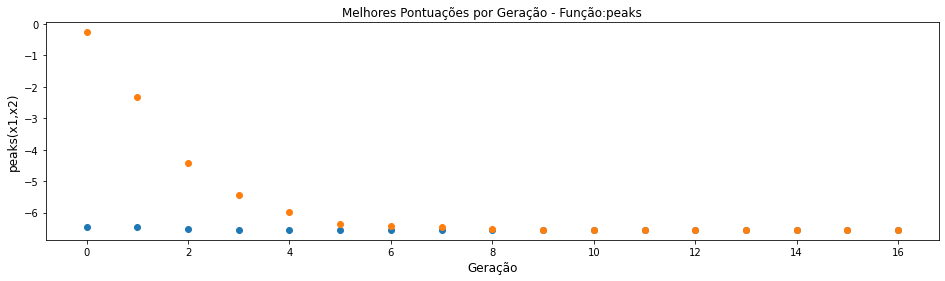

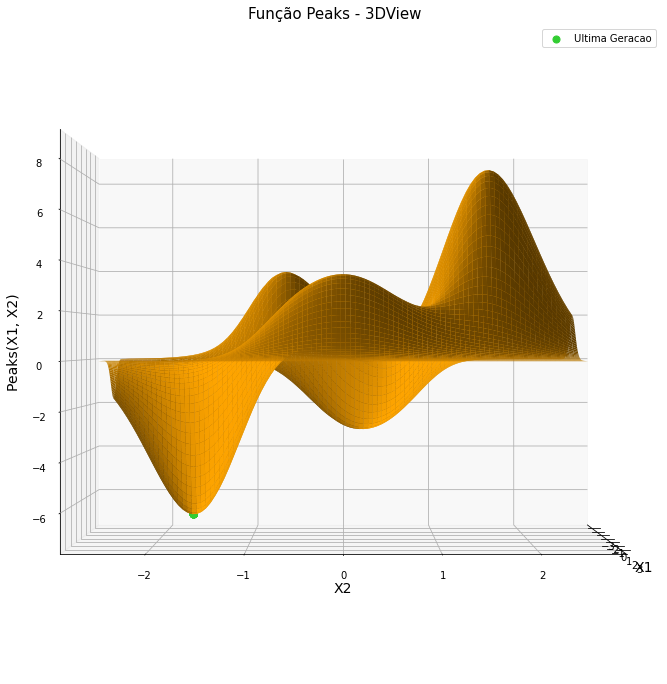

In [6]:
algoritmoPeaks = Algoritmo_Swarm(50,tipo='peaks')
outputPeaks = algoritmoPeaks.run(w=0.3,c1=1,c2=1,maxgen=30)

PlotMelhoresPontuacoes(outputPeaks,tipo='peaks')
Plot3D(algoritmoPeaks,'Peaks')

### Análise problema Peaks

- Após a execução do algoritmo e a plotagem do gráfico acima, é possível observar:
    - Uma evolução bastante rápida para o problema Peaks
    - O algoritmo convergiu por volta da 16ª geração, com sua melhor posição/Pontuação em:

        - x1 = 0.22831047

        - x2 = -1.6255558

        - F(x1,x2) = -6.551088793149768
    
    - Analisando o gráfico em 3D é possível ver que todas as Partículas da última geração ja se encontram no mínimo global e comparando com o resultado esperado da posição em [0.228, -1.625] e F(x1,x2) em -6.5511 é possível concluir que o algoritmo foi executado com sucesso.

Geração Atual:27/40                  Melhor Pontuacao:-19.999999744754888
Posicao da Melhor Pontuacao:[-8.37002119e-06 -2.89131646e-06]


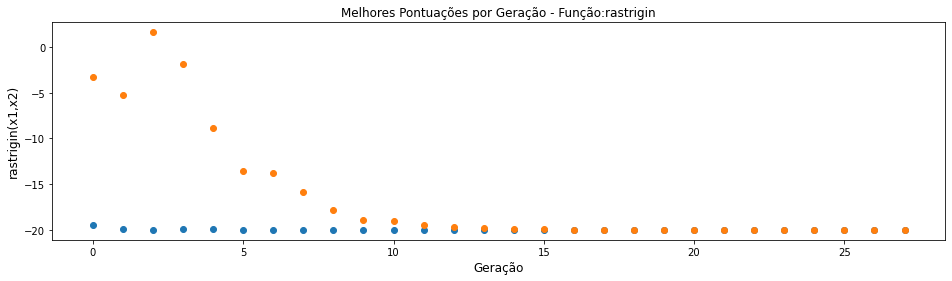

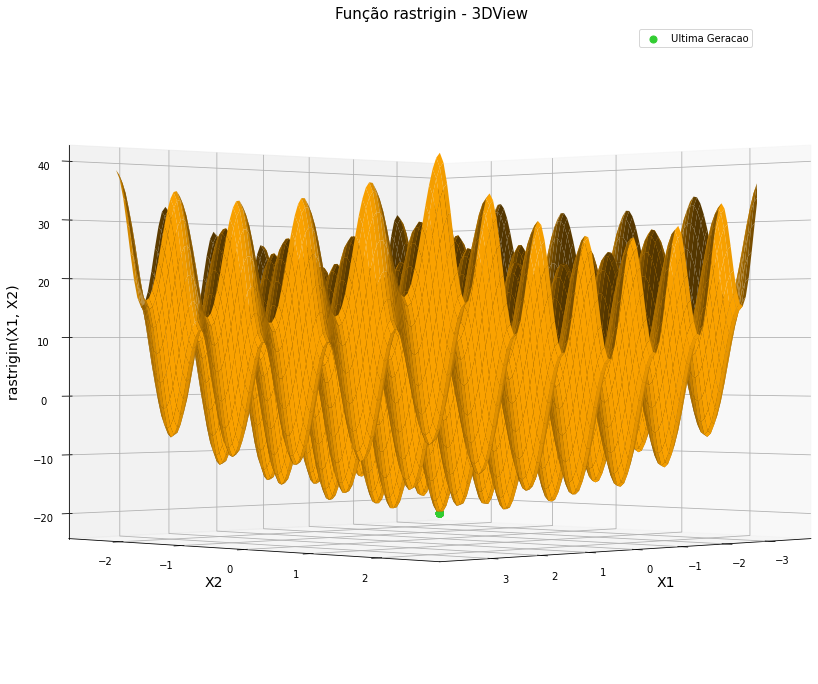

In [7]:
algoritmoRastrigin = Algoritmo_Swarm(50,tipo='rastrigin')
outputRastrigin = algoritmoRastrigin.run(w=0.5,c1=1,c2=1,maxgen=40)
PlotMelhoresPontuacoes(outputRastrigin,tipo='rastrigin')
Plot3D(algoritmoRastrigin,'rastrigin',view=[0,45])

### Análise problema Rastrigin

- Após a execução do algoritmo e a plotagem do gráfico acima, é possível observar:
    - Uma evolução bastante rápida para o problema Peaks
    - O algoritmo convergiu por volta da 27ª geração, com sua melhor posição/Pontuação em:

        - x1 = -8.37002119e-06  (praticamente 0)

        - x2 = -2.89131646e-06 (praticamente 0)

        - F(x1,x2) = -19.999999744754888 (praticamente 20)
    
    - Analisando o gráfico em 3D é possível ver que todas as Partículas da última geração ja se encontram no mínimo global e comparando com o resultado esperado da posição em [0,0] e F(x1,x2) em -20 é possível concluir que o algoritmo foi executado com sucesso.
    
    - Nessa Função, houve alguns momentos em que o algoritmo convergia para um mínimo local perto do mínimo global. Isso acontece pois essa função possuí varios valores de mínimos locais que vao se aproximando, cada vez mais, do mínimo global, como pode ser observado também no gráfico em 3D